# Neural Spline Flow Tutorial

This notebook is intended as an example of usage of the `NeuralSplineFlow` class from `spqr` module, where we have trained the bijector to replicate a simple 2-D feature distribution.

This notebook is divided in the following sections:

1. introduction;
2. creation of a toy dataset and a few helper functions;
3. initializing a NeuralSplineFlow bijector;
4. training;
5. results and conclusion.

## 1. Introduction

A *normalizing flow* is a bijective and differentiable transformation $g_{\theta}$, which can map a vector of features with D-dimensions $x$ in a transformed vector $g_\theta(x) \sim z$ with D-dimension. Since the transformation $g$ is differentiable, the probability distribution of $z$ and $x$ are linked through a simple change of variable:

   $ p(x) = p(z) \cdot det \Bigl(\dfrac{d g_\theta}{d x}\Bigr) $

Hence the name *normalizing*.

The parameters $\theta$ can be trained to map a simple distribution $p(z)$ (tipically a gaussian) into the feature distribution $p(x)$ through the inverse transformation $g_\theta^{-1}$.

Following the idea in the article [Durkan et al.](https://arxiv.org/abs/1906.04032), we have implemented a *normalizing flow* transformation which uses as bijector a [rational quadratic spline](https://www.tensorflow.org/probability/api_docs/python/tfp/bijectors/RationalQuadraticSpline). To learn the correlation between features (improves the expressivity of the transformation) and to avoid a too large computation time for the Jacobian, bijectors must be composed in chain allowing at each step some variables to be unchanged. The algorithm we use to this purpose is a [RealNVP](https://www.tensorflow.org/probability/api_docs/python/tfp/bijectors/RealNVP).

### Package required to run this notebook

First, we need to download from the GitHub repository [diglm](https://github.com/MarcoRiggirello/diglm.git) the necessary modules and import the required packages.

In [ ]:
! git clone https://github.com/MarcoRiggirello/diglm.git

In [44]:
import os
import sys

py_file_location = "diglm/src"
sys.path.append(py_file_location)

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns # plot package
import sklearn.datasets as skd # where we can find a simple example
import tensorflow as tf
from tensorflow_probability import bijectors as tfb
from tensorflow_probability import distributions as tfd

from spqr import NeuralSplineFlow as NSF

## 2. Toy dataset

We load a simple dataset from `sklearn.datasets`, `moons`. This dataset is often used ([FFJORD demo](https://www.tensorflow.org/probability/examples/FFJORD_Demo)) to illustrate the functioning of a *normalizing flow*.

We also define in this section a function to plot data and visualize them nicely.

<AxesSubplot:xlabel='x1', ylabel='x2'>

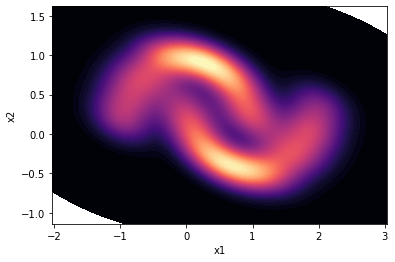

In [45]:
BATCH_SIZE = 256
DATASET_SIZE = BATCH_SIZE * 2
SAMPLE_SIZE = DATASET_SIZE

# load the dataset
moons = skd.make_moons(n_samples=DATASET_SIZE, noise=.06)[0]
# transform the dataset to a `tf.data.Dataset` object for autobatching,
# multiprocessing, speed up etc... 
moons_ds = tf.data.Dataset.from_tensor_slices(moons.astype(np.float32))
moons_ds = moons_ds.prefetch(tf.data.experimental.AUTOTUNE)
moons_ds = moons_ds.cache()
moons_ds = moons_ds.batch(BATCH_SIZE)

moons = pd.DataFrame(moons, columns=['x1', 'x2'])

# let's visualize the moons dataset. which our algorithm will
# hopefully learn to reproduce
sns.kdeplot(data=moons, x='x1', y='x2',
            cmap='magma', fill=True,
            thresh=0, levels=100)

### Plot helper function

Now let's define a plot function suited to our purpose of visualizing training progress of the algorithm.

In [46]:
def plot(trans_sample,
         counter,
         nfeatures=2):
    """
    Plot function to display results. More sample can be plotted
    on the same figure. We use it to plot a sample from the
    transformed distribution and compair it to the moon datasample

    """
    # plot the moon dstribution
    ax_s = sns.kdeplot(data=moons, x='x1', y='x2',
            cmap='magma', fill=True,
            thresh=0, levels=100)

    # split trans_sample data into single features
    x_s, y_s = np.squeeze(np.split(trans_sample, nfeatures, axis=1))
    # add a scatterplot of the trans_sample
    ax_s.scatter(x_s, y_s, color='yellow', alpha=0.6)

    ax_s.set(xlim=(-2, 3), ylim=(-1.1, 1.6))
    ax_s.set_title(f'training epoch = {counter}')

    # save the figure
    name = f'training_fig{counter}.jpeg'
    plt.savefig(name)

## 3. Initialization of NSF

We initialize the NeuralSplineFlow bijector and define a base distribution $z$ as a multivariate normal distribution with $\mu = [0, 0]$ and cov = 
$ 
\begin{pmatrix}
1 & 0 \\
0 & 1 \\
\end{pmatrix}
$


Then, we plot the inverse distribution of the bijector before any training and compair it to the *moon* distribution.
Hopefully the algorithm will learn to reproduce this distribution after training.

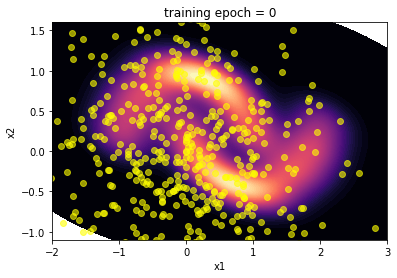

In [47]:
neural_spline_flow = NSF(splits=2) # with 2 features 2 splits is enough 

base_loc = np.array([0.0, 0.0]).astype(np.float32)
base_sigma = np.array([1., 1.]).astype(np.float32)
base_distribution = tfd.MultivariateNormalDiag(base_loc, base_sigma)
transformed_distribution = tfd.TransformedDistribution(distribution=base_distribution,
                                                       bijector=neural_spline_flow)

# plotting
plot(transformed_distribution.sample(SAMPLE_SIZE), 0)
plt.show()

## 4. Model training

We define a train step function following the [keras example](https://keras.io/guides/writing_a_training_loop_from_scratch/). With a normalizing flow it is straightforward to choose the objective function to minimize:

\begin{equation}
- \sum \log{p(x_i; \theta)}
\end{equation}

In [48]:
@tf.function
def train_step(optimizer, target_sample):
    with tf.GradientTape() as tape:
        loss = -tf.reduce_mean(transformed_distribution.log_prob(target_sample))
    variables = tape.watched_variables()
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return loss

We are ready to perform the training!

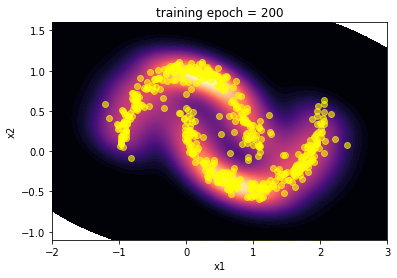

In [49]:
# hyper parameters for the training
LR = .6e-3
NUM_EPOCHS = 200
learning_rate = tf.Variable(LR, trainable=False)
optimizer = tf.keras.optimizers.Adam(learning_rate)

loss = 0
history = [] # list to store loss values across training loops
fig_list = []

# Training loop
for epoch in range(NUM_EPOCHS):
    if epoch % 10 == 9:
        fig_name = f'training_fig{epoch + 1}.jpeg'
        fig_list.append(fig_name)
        plot(transformed_distribution.sample(SAMPLE_SIZE), epoch + 1)
    for batch in moons_ds:
        loss = train_step(optimizer, batch)
        history.append(loss)
    

## 5. Results ...

Here we summarize the results of the training:

1. Using the `make_gif` function we realize a gif of the evolution of the transformed distribution during training;
2. we plot the history of the loss during the training.


In [1]:
from plot_utils import make_gif

# gif showing training across epochs
make_gif(fig_list, output_gif="spqr.gif")

NameError: name 'fig_list' is not defined

![SegmentLocal](spqr.gif "spqr")


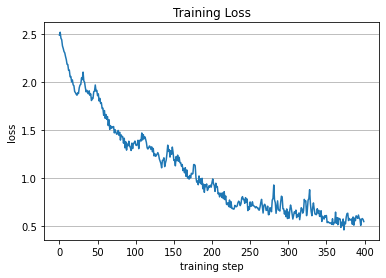

In [51]:
# Now we plot loss across epochs
plt.title('Training Loss')
plt.plot([i for i in range(len(history))],
        history)
plt.xlabel('training step')
plt.ylabel('loss')
plt.grid(axis='y')
plt.show()

## ... and conclusions

The capability of the SpQR algorithm to reproduce the toy *moon* distribution is evident looking at the images of the comparison between the two distributions.

The "visual" effect is actually a good way to evaluate this algorithm, since it is often applied in image generation as an alternative to GAN. Craving for a little more quantitative, we performed a Kolmogorov-Smirnov test on the marginalized distribution of the two features *x1* and *x2*.

In [52]:
from scipy.stats import ks_2samp

# getting samples
TEST_SIZE = 1000
trans = transformed_distribution.sample(TEST_SIZE)
#slicing and preparing arrays to perform the test
x1_trans, x2_trans = np.squeeze(np.split(trans, 2, axis=1))
x1_moons, x2_moons = np.squeeze(np.split(moons.to_numpy(), 2, axis=1))

# calculating statistic from K-S test and p-values
stat_1, pval_1 = ks_2samp(x1_trans, x1_moons)
stat_2, pval_2 = ks_2samp(x2_trans, x2_moons)

print(f'p-value x1 distribution = {pval_1}')
print(f'p-value x2 distribution = {pval_2}')

p-value x1 distribution = 0.9800638928128416
p-value x2 distribution = 0.15898807617859714


The *p-value* for the two tests are better than 0.1. At least, this means that the algorithm learnt quite well to simulate the two features distributions.

With the current model, better results may be reached through hyper-parameters tuning, since a more extensive training would not brought an improvement in loss, which reached its *plateau*.